# Fitting empirical data using Gaussian Mixture Models

In this notebook we aim at studying the problem of estimating the underling probability distribution of a phenomenon given empirical observations. More precisely, given IID random variables $X_i \sim P_X$ with observations $\{x_1, ..., x_n\}$, we want to estimate from the observations: How many modes has $P$? If we approximate $P$ by a combination of Gaussian distributions, how many distributions we actually need to fit the data? Which are the optimal parameters of these Gaussian distributions? 

Refs:
* https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html
* https://github.com/BenjaminDoran/unidip
* Larry Wasserman, "All of Statistics".

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import mixture
import scipy.stats as stats
import math
from matplotlib import cm
import seaborn as sns
from unidip import UniDip  # make sure you installed it, pip instrall unidip

### Illustrate with an example a toy example 

Gaussian estimation score: {'eval_score': -1.2504215204637386, 'fit_score': -1.3545458553846206}
Number of modes detected by Unidip 5


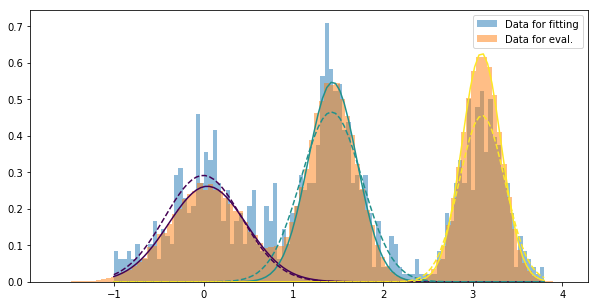

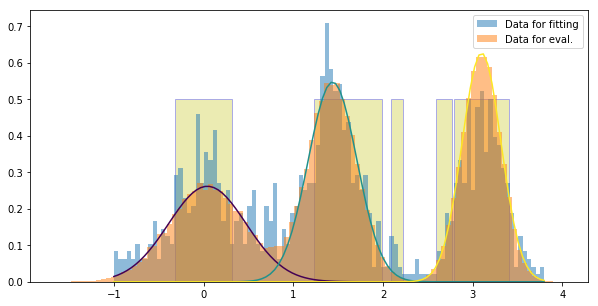

In [67]:
# === Set distribution parameters === #
num_modes = 3  # number of modes in the data
distance = 1  # min distance between the modes (the distance is with respect to the sdt., e.g., dist = 1 means a std)
sigma = 1  # orther of magnitude for the std of each mode (the actual values are random, this sets only a order of magnitude)
n = 1000  # number of observations for fitting/training (the number of test samples is large and fixed)
noise_power = .15  # to the modes, a background of noise uniformly samples is added, this set the power.
# E.g. .9 means that 90% of the data is noise

# Run the cells where "Experiment" class is defined prioir running this cell. 
experiment = Experiment(num_modes=num_modes, distance=distance, sigma=sigma, 
                        n=n, noise_power=noise_power)  # Init the experiment.
experiment.simulate_data(verbose=0)  # Similate a pdf with the properties set before and samples observations from it. 
experiment.fit_gaussians(num_gaussians=3, verbose=1)  # Fit a gaussian mixture <-- you can set the number of gaussians
print('Gaussian estimation score: {}'.format(experiment.gaussian_estimation.score))  # print the log likelhood of the estimation
experiment.fit_unidip(p_val = 0.05, ntrials = 200, verbose=1)  # use unidip test and find the statistically significant modes. 
print('Number of modes detected by Unidip {}'.format(experiment.dip_estimation.num_modes))  # print the num of modes detected. 

### Explore the behaviour of these methods in different conditions. 

In [ ]:
import pandas as pd
from tqdm import tqdm

modes = [1,2,3]
sigmas = [1]
dists = [.7,1,1.3,2]
power_levels = [0, .1]
num_runs = 10
n = 500

print('{} experiments will be performed... this may take a while.'.format(len(modes)*len(sigmas)*len(dists)*len(power_levels)*num_runs))

results_gaussian = pd.DataFrame()
for num_modes in tqdm(modes):
    for sigma in sigmas:
        for dist in dists:
            for power in power_levels:
                for run in range(num_runs):
                    # Run the cells where "Experiment" class is defined prioir running this cell. 
                    experiment = Experiment(num_modes=num_modes, distance=dist, sigma=sigma, n=n, noise_power=power)  # Init 
                    experiment.simulate_data(verbose=0)  
                    
                    k_min = np.max([1, num_modes-3])
                    k_max = np.max([6, num_modes+3])
                    ks = np.arange(k_min, k_max)  # the modes tested using the gaussian mixture models
                    for k in ks: 
                        experiment.fit_gaussians(num_gaussians=k, verbose=0)  
                        fit_score = experiment.gaussian_estimation.score['fit_score']
                        eval_score = experiment.gaussian_estimation.score['eval_score']
                        
                        new_result = pd.DataFrame({'num_modes':[num_modes], 'sigma':[sigma], 'dist':[dist], 'noise_power':[power], 
                                                   'diff':[k-num_modes], 'fit_score':[fit_score], 'eval_score':[eval_score], 'run':[run]})
                        results_gaussian = pd.concat([results_gaussian, new_result], ignore_index = True)

                        
results_unidip = pd.DataFrame()
p_vals = [0.01, 0.05, 0.1]

for num_modes in tqdm(modes):
    for sigma in sigmas:
        for dist in dists:
            for power in power_levels:
                for run in range(num_runs):
                    # Run the cells where "Experiment" class is defined prioir running this cell. 
                    experiment = Experiment(num_modes=num_modes, distance=dist, sigma=sigma, n=n, noise_power=power)  # Init 
                    experiment.simulate_data(verbose=0)  
                    
                    for p_val in p_vals:
                        experiment.fit_unidip(p_val = p_val, ntrials = 200, verbose=0)
                        estimated_num_of_modes = experiment.dip_estimation.num_modes
                        
                        new_result = pd.DataFrame({'num_modes':[num_modes], 'sigma':[sigma], 'dist':[dist], 'noise_power':[power], 
                                                   'diff':[estimated_num_of_modes-num_modes], 'p_val':[p_val], 'run':[run]})
                        results_unidip = pd.concat([results_unidip, new_result], ignore_index = True)


  0%|          | 0/3 [00:00<?, ?it/s]

240 experiments will be performed... this may take a while.


In [52]:
# Save the results
results_gaussian.to_csv('../tmp/results_gaussian.csv', index=False)
results_unidip.to_csv('../tmp/results_unidip.csv', index=False)

### Explore the performance of the gaussian mixture fitting

In [55]:
results_gaussian = pd.read_csv('../tmp/results_gaussian.csv')
results_unidip = pd.read_csv('../tmp/results_unidip.csv')

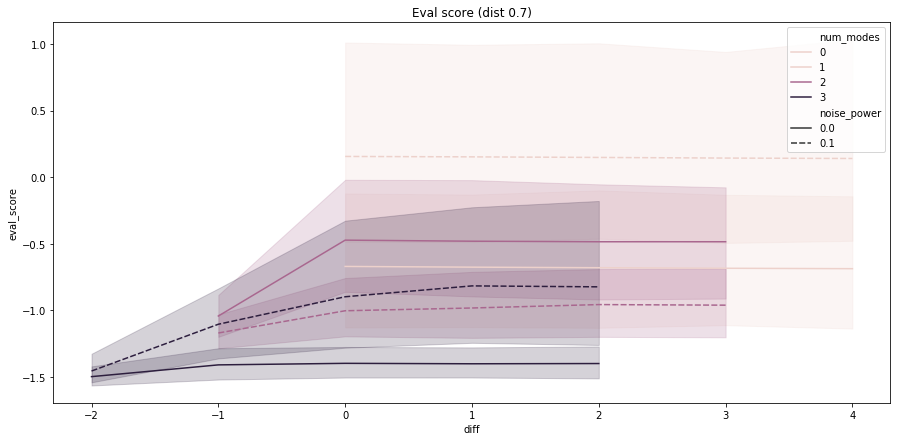

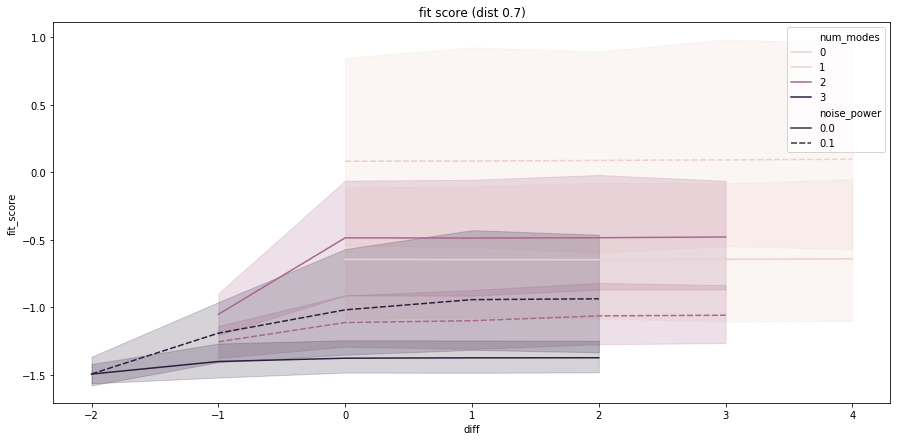

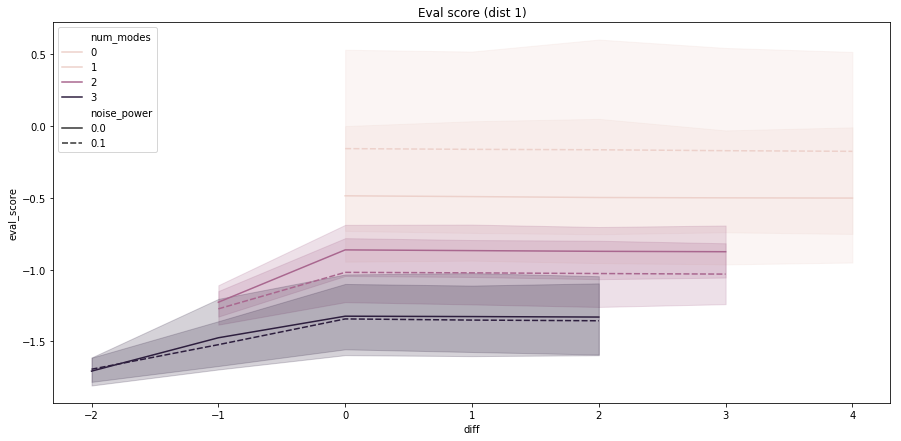

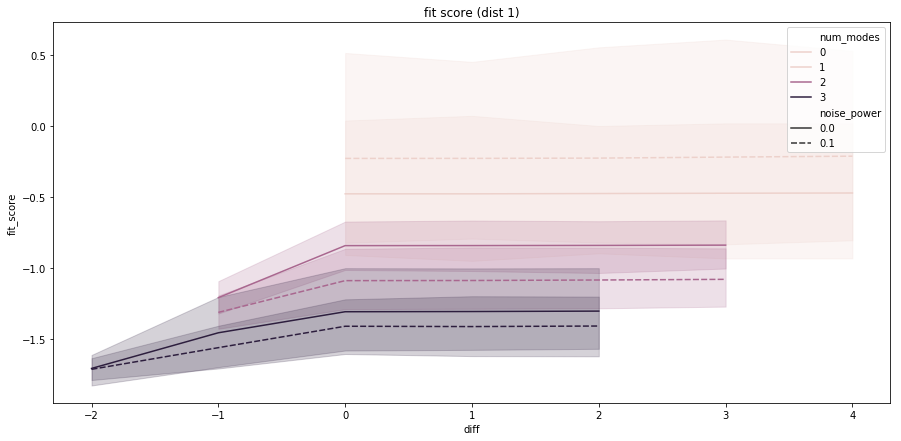

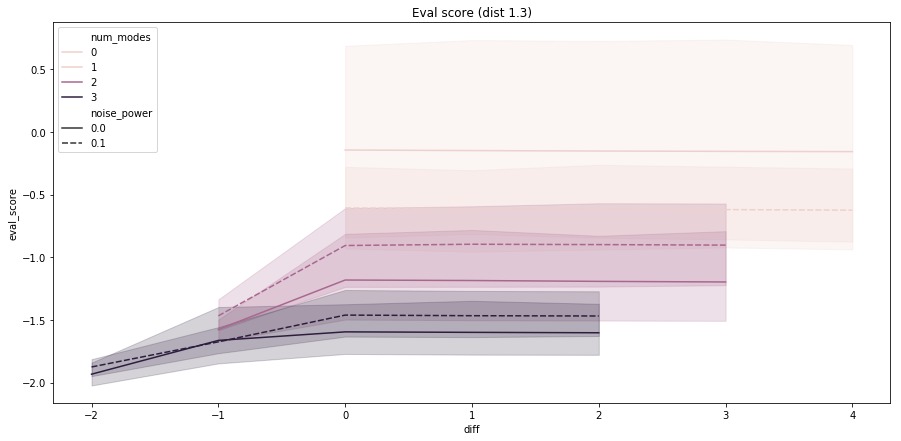

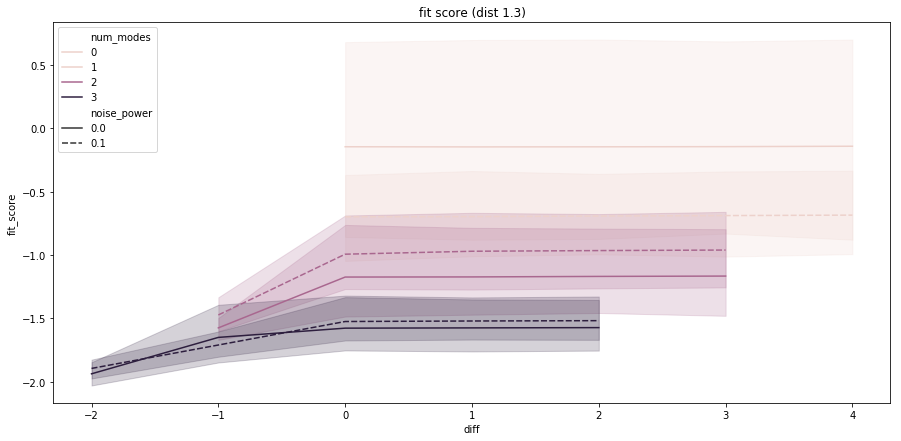

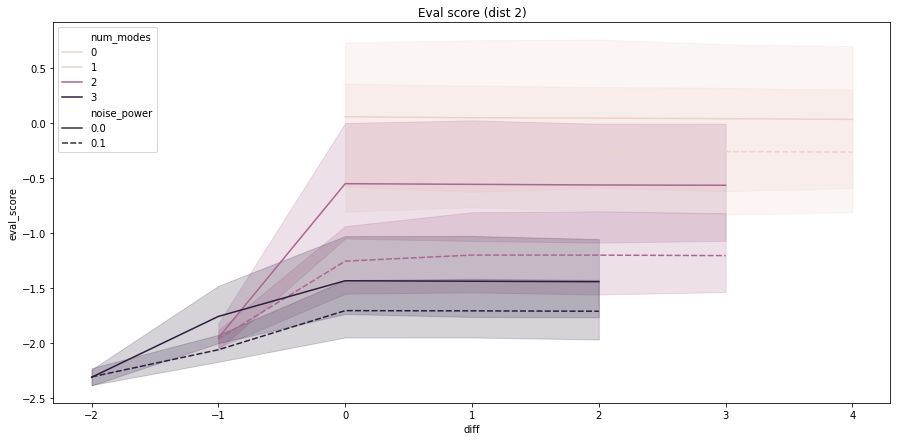

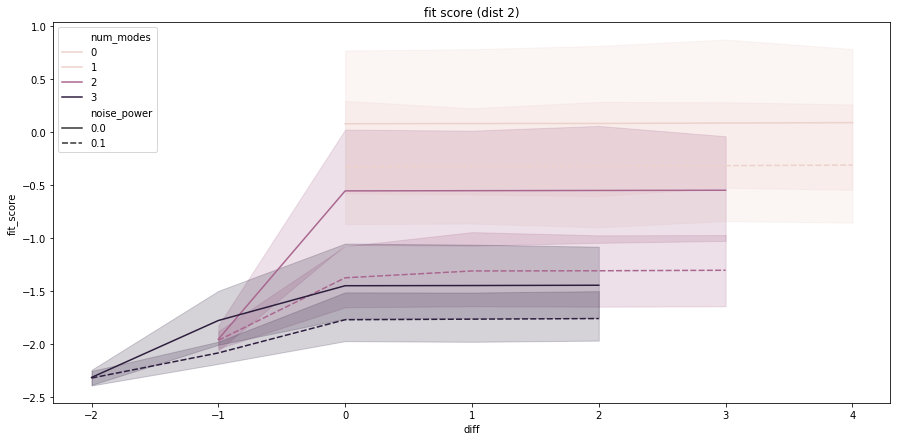

In [56]:
for dist in dists:
    auxdf = results_gaussian[results_gaussian['dist']==dist]
    auxdf = auxdf[['diff', 'eval_score', 'num_modes','noise_power']]
    plt.figure(figsize=[15,7])
    ax = sns.lineplot(x="diff", y="eval_score", hue="num_modes", style='noise_power', data=auxdf)
    plt.title('Eval score (dist {})'.format(dist))

    auxdf = results_gaussian[results_gaussian['dist']==dist]
    auxdf = auxdf[['diff', 'fit_score', 'num_modes','noise_power']]
    plt.figure(figsize=[15,7])
    ax = sns.lineplot(x="diff", y="fit_score", hue="num_modes", style='noise_power', data=auxdf)
    plt.title('fit score (dist {})'.format(dist))

### Explore unidip method

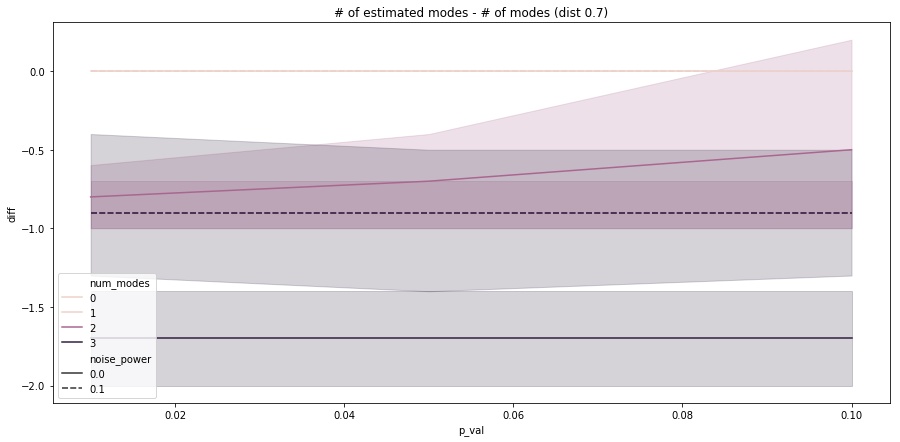

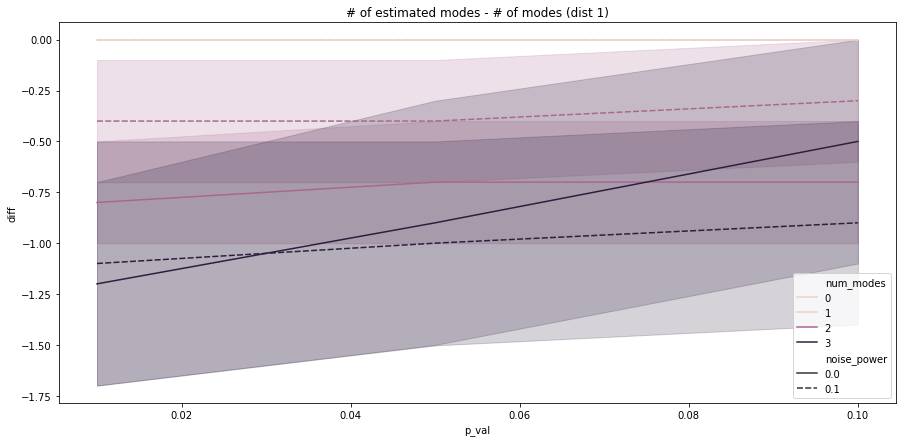

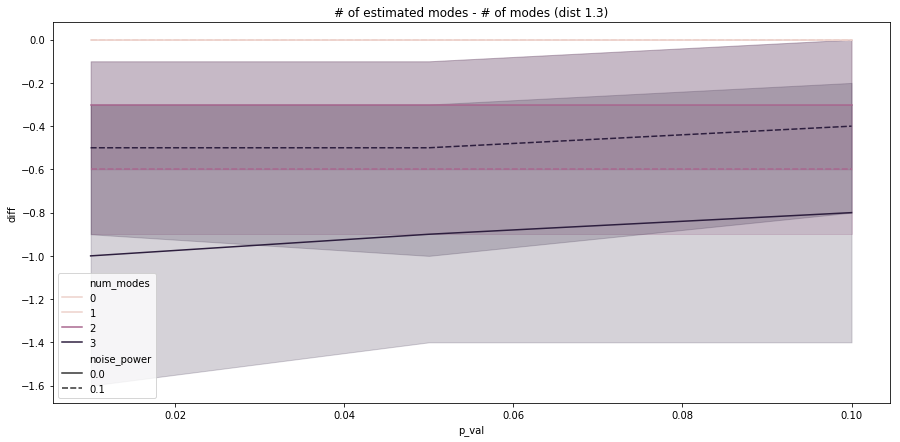

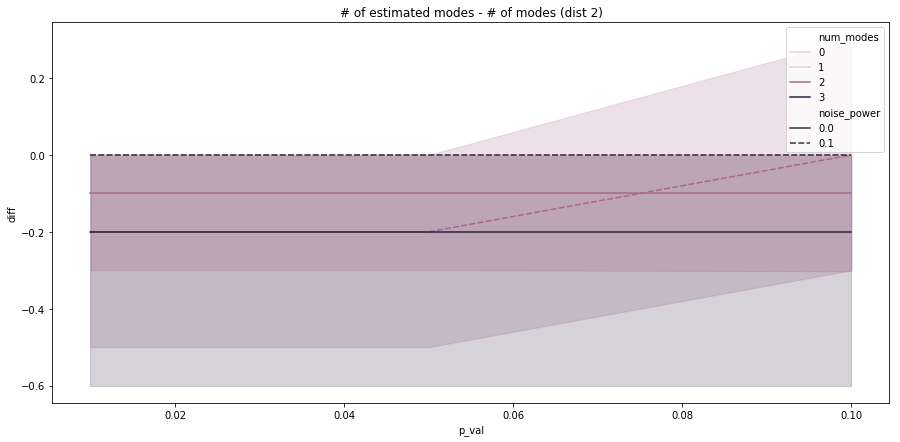

In [57]:
for dist in dists:
    auxdf = results_unidip[results_unidip['dist']==dist]
    auxdf = auxdf[['diff', 'p_val', 'num_modes', 'noise_power']]
    plt.figure(figsize=[15,7])
    ax = sns.lineplot(x='p_val', y='diff', hue='num_modes', style='noise_power', data=auxdf)
    plt.title('# of estimated modes - # of modes (dist {})'.format(dist))

In [79]:
# Random 

from numba import jit

@jit
def test(n):
    a = np.random.rand(n)
    for i in range(len(a)):
        if i > 0:
            a[i] = a[i]+a[i-1]
    return a

%timeit test(1000)

def test(n):
    a = np.random.rand(n)
    for i in range(len(a)):
        if i > 0:
            a[i] = a[i]+a[i-1]
    return a

%timeit test(1000)

5.99 µs ± 490 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)
292 µs ± 2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


## ToDo
- 

------------------------------------------

# Definitions
You may have to run some of these cells before running the experiments.

In [2]:
class Gaussian_estimation():
    def __init__(self):
        self.estimator = None
        self.score = None
        self.pdf_parameters = None
        
        
class Dip_estimation():
    def __init__(self):
        self.intervals = None
        self.num_modes = None
        
        
class Experiment():
    def __init__(self, num_modes=4, distance=1, sigma=1, n=100, noise_power=0):
        """
        Init. the parameters of the experiment. Set the number of modes in the data,
        the distance between modes (relative to the std, for example distance = 2 means
        a minimial distance of two std between the modes). Sigma represent the average 
        std of the gaussians (again, it sets an order of magnitud not the precise values).
        n sets the number of empirical observation sampled from this distribution (this 
        number sets only the number of observations for "fitting/training", we always use
        a large number of samples for testing, e.g. 1e5). Finally, noise power sets the 
        amount of uniform noise we add to the fitting data, for example, noise_power=.1 
        means 10% of the training samples will come from an uniform distribution. Eval 
        samples are kept clean (i.e. this data does not contain a background unif. dist).
        """
        self.parameters = {'num_modes': num_modes, 
                           'distance': distance, 
                           'sigma': sigma, 
                           'n': n,
                           'noise_power': noise_power}
    
    def simulate_data(self, verbose=0):
        """
        Simulate synthetic data. The parameters as set when an instance of Experiment
        is initiated. 
        """
        k = self.parameters['num_modes']  # number of Gaussians
        sigma_0 = self.parameters['sigma']  # Set an order of magnitudo for the standard deviation
        dist_0 = self.parameters['distance']  # Min dist between the modes (relative to the std)
        
        sigmas = sigma_0*np.random.random((k,))  # The std of each of the modes 
        dist = dist_0*sigma_0 # min distance between the gaussians
        means = -dist + np.cumsum(dist + dist*np.random.random((k,)))  # The mean of each gaussian will have a distance in [dist, 2*dist]
        priors = np.random.random((k,))+1
        priors /= priors.sum()  # normalized prior of each Gaussian
        
        self.pdf_parameters = {'means': means, 'stds': sigmas, 'priors': priors}
        
        # === Sample empirical observations from the distribution === #
        noise_power = self.parameters['noise_power']  # the proportion of samples comming from a Unif dist.
        n_fit = self.parameters['n']
        n_fit_excluding_noise = int(np.round((1-noise_power)*n_fit))
        n_eval = 1e5  # <--- This set the number of samples for testing!  [YOU MAY WANT TO TUNE THIS]
        
        N = n_fit_excluding_noise + n_eval  # sample all the point at once and then split
        Ns = (N*priors).astype('int')
        x = np.array([])
        for i in range(k):
            new_x = np.random.normal(loc=means[i],scale=sigmas[i],size=(Ns[i],))
            x = np.append(x,new_x)          
            

        # Shuffle and split in train and test, 
        np.random.shuffle(x)
        x_fit = x[:n_fit_excluding_noise]
        x_eval = x[n_fit_excluding_noise:]
        
        # Now add the noisy samples comming from a Unif dist
        if noise_power>0: 
            noise = np.random.uniform(low=x_fit.min(), high=x_fit.max() , size=(int(n_fit*noise_power),))
            x_fit = np.append(x_fit, noise)
            np.random.shuffle(x_fit)
            
        self.x_fit = x_fit
        self.x_eval = x_eval
        
        if verbose>0:
            plt.figure()
            plt.hist(x_fit, bins=100, density=True, alpha=.5)
            plt.hist(x_eval, bins=100, density=True, alpha=.5)
            plt.legend(['Data for fitting', 'Data for evaluation'])
            xx = np.linspace(x.min(), x.max(), 100)
            for i in range(k):
                plt.plot(xx, priors[i]*stats.norm.pdf(xx, means[i], sigmas[i]))
        
    def fit_gaussians(self, num_gaussians=1, verbose=0):
        x_fit = self.x_fit.reshape(-1,1)
        x_eval = self.x_eval.reshape(-1,1)
        
        # ==== Set fitting parameters,  ===== #
        k_e = num_gaussians  # Set the number of gaussians 
        # ----------------------------------- #

        # Set algorithm parameters
        gm = mixture.GaussianMixture(n_components=k_e, tol=0.001, reg_covar=1e-10, max_iter=100, 
                                     n_init=30, init_params='kmeans', verbose=0, verbose_interval=10)
        # Fit
        gm.fit(x_fit)
        fit_score = gm.score(x_fit)
        eval_score = gm.score(x_eval)
        
        # if verbose>0:
            # print('Score on fit/eval data: {}/{}'.format(fit_score, eval_score))
        
        priors_est = gm.weights_.squeeze()
        means_est = gm.means_.squeeze()
        sigmas_est = np.sqrt(gm.covariances_.squeeze())  # var --> std

        # Order the predictions to match the ground truth 
        # (the order is arbitrary)
        if k_e == 1: 
            means_est = np.array([means_est])
            priors_est = np.array([priors_est])
            sigmas_est = np.array([sigmas_est])
        if k_e>1:  
            ind = np.argsort(means_est)
            means_est = means_est[ind]
            priors_est = priors_est[ind]
            sigmas_est = sigmas_est[ind]
    
        # Save the parameters
        gaussian_estimation = Gaussian_estimation()
        gaussian_estimation.estimator = gm
        gaussian_estimation.score = {'fit_score': fit_score, 'eval_score': eval_score}
        gaussian_estimation.pdf_parameters = {'means': means_est, 
                                              'stds': sigmas_est, 
                                              'priors': priors_est}
        
        self.gaussian_estimation = gaussian_estimation
        # The score represent the log likelihood for the data:
        # I.E.: 1/#X sum_xi ln(P(x_i|theta))    
        
        # --------------------------------------------------------- #
        # visualization and debugging.
        if verbose>0:
            means = self.pdf_parameters['means']
            sigmas = self.pdf_parameters['stds']
            priors = self.pdf_parameters['priors']
            # print('Priors Ground truth / estimated\n {}/{}'.format(priors, priors_est))
            # print('Means Ground truth / estimated\n {}/{}'.format(means, means_est))
            # print('Std Ground truth / estimated\n {}/{}'.format(sigmas, sigmas_est))        
            
            # --------------------------------- #
            # Plot ground truth and fitter
            plt.figure(figsize=[10,5])
            plt.hist(x_fit, bins=100, density=True, alpha = .5)
            plt.hist(x_eval, bins=100, density=True, alpha = .5)    
            plt.legend(['Data for fitting', 'Data for eval.'])
            xx = np.linspace(self.x_fit.min(), self.x_fit.max(), 100)
    
            n = np.max([k_e, len(priors)])
            colors = cm.get_cmap('viridis', n)
            for i in range(len(priors)):
                plt.plot(xx, priors[i]*stats.norm.pdf(xx, means[i], sigmas[i]), color=colors(i))
            for i in range(k_e):
                plt.plot(xx, priors_est[i]*stats.norm.pdf(xx, means_est[i], sigmas_est[i]), '--', color=colors(i))
                
    def fit_unidip(self, p_val = 0.05, ntrials = 1000, verbose=0):
        """
        Here we test the code provided in: https://github.com/BenjaminDoran/unidip
        See that reference for more information and a descritpion of the method. 
        """
        dat = self.x_fit.squeeze()

        # sort data so returned indices are meaningful
        dat = np.msort(dat)

        # get start and stop indices of peaks 
        intervals = UniDip(dat, alpha=p_val, ntrials=ntrials, debug=0).run()

        # Get the x coordinates of each interval
        intervals_x = []
        for i in intervals:
            intervals_x.append((dat[i[0]],dat[np.min([i[1],len(dat)-1])])) 
        
        dip_estimation = Dip_estimation()
        dip_estimation.num_modes = len(intervals_x)
        dip_estimation.intervals = intervals_x
        self.dip_estimation = dip_estimation
        
        from matplotlib.collections import PatchCollection
        from matplotlib.patches import Rectangle
        if verbose>0:
            means = self.pdf_parameters['means']
            sigmas = self.pdf_parameters['stds']
            priors = self.pdf_parameters['priors']
            
            plt.figure(figsize=[10,5])
            
            # Plot the observations
            plt.hist(self.x_fit, bins=100, density=True, alpha = .5)
            plt.hist(self.x_eval, bins=100, density=True, alpha = .5)    
            plt.legend(['Data for fitting', 'Data for eval.'])
            xx = np.linspace(self.x_fit.min(), self.x_fit.max(), 100)
            n = len(priors)
            colors = cm.get_cmap('viridis', n) 
            # Plot the ground truth distributions
            for i in range(len(priors)):
                plt.plot(xx, priors[i]*stats.norm.pdf(xx, means[i], sigmas[i]), color=colors(i))
            
            # Plot the regions selected by the method
            boxes = []
            for ii in intervals_x:
                rec = Rectangle((ii[0], 0), ii[1]-ii[0], .5)
                boxes.append(rec)

            pc = PatchCollection(boxes, facecolor='y', alpha=.3, edgecolor='b')
            # Add collection to axes
            ax = plt.gca()
            ax.add_collection(pc)       
        